# MNIST Classification with a Fully-Connected Net in TensorFlow 

<h2>Imports / magic (%)</h2>

In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from mnist_loader import load

# compiles operation graphs at intermediate steps (instead of at end)
sess = tf.InteractiveSession()

<h2>Hyper Parameters</h2>

In [2]:
# Hyper params and constants
IMAGE_SIZE = 28

INPUT_SIZE = 784
HIDDEN_SIZE = 200
OUTPUT_SIZE = 10

LEARNING_RATE = 0.3
EPOCHS = 1000
##MINIBATCH_SIZE = 5

# File to save trained model to
SAVE_FILE = "C:/Users/Sanjay/Desktop/model"

## Load Data and Input Placeholders
<p>The input matrix has
<ul>
    <li>First dimension = training examples
    <li>Second dimension = features
</ul></p>
<p>ie. an m x n matrix has m training examples each with n features.</p>

Retrieving standard mnist set
Loaded data set


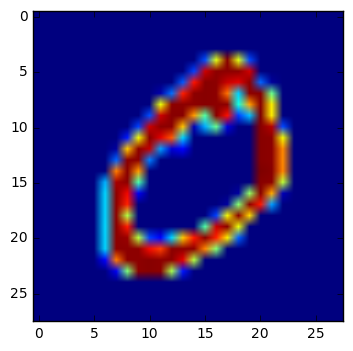

In [3]:
# Load data
path = "Data\mnist.pkl.gz"
train_data, validation_data, test_data = load(path)

# Tuples of (img, label) --> list of imgs, list of labels
train_imgs, train_labels = zip(*train_data)
train_imgs = np.vstack(train_imgs)
# Tuples of (img, label) --> list of imgs, list of labels
vali_imgs, vali_labels = zip(*validation_data)
vali_imgs = np.vstack(vali_imgs)
# Tuples of (img, label) --> matrix of imgs, list of labels
test_imgs, test_labels = zip(*test_data)
test_imgs = np.vstack(test_imgs)

# Placeholder vars
# float pixel values of images
inputs = tf.placeholder(tf.float32, name="inputs")
# integer target labels of each image
labels = tf.placeholder(tf.int32, name="labels")

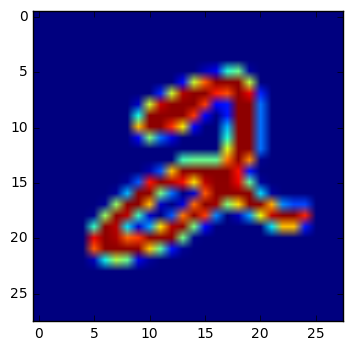

In [9]:
# Change index of train_imgs to see other images
plt.imshow(np.reshape(train_imgs[5], (IMAGE_SIZE, IMAGE_SIZE)))

<h2>Initialize Layers:</h2>
<p>Each weight matrix has:
<ul>
    <li>First dim = size of previous layer
    <li>Second dim = size of current layer
</ul></p>

<p>for multiplication with inputs. The individual weights are randomly initialized with:
<ul>
    <li>Mean = 0
    <li>Standard devation = 1 / sqrt(n), n = size of previous layer
</ul></p>
<p>This initialization prevents saturation in activation function with a narrow distribution and (ideally) leads to faster learning.</p>
<p>The biases are initialized as an all-zero column vector.</p>

In [4]:
with tf.name_scope("hidden"):
    weights = tf.Variable(
        tf.truncated_normal([INPUT_SIZE, HIDDEN_SIZE], 
                             stddev=(1 / (INPUT_SIZE ** 0.5))),
        name="weights")
    biases = tf.Variable(tf.zeros([HIDDEN_SIZE]), name="biases")
    # inputs is placeholder, weights and biases are Variables
    hidden = tf.nn.relu(tf.matmul(inputs, weights) + biases)

with tf.name_scope("output"):
    weights2 = tf.Variable(
        tf.truncated_normal([HIDDEN_SIZE, OUTPUT_SIZE], 
                             stddev=(1 / (HIDDEN_SIZE ** 0.5))),
        name="weights")
    biases2 = tf.Variable(tf.zeros([OUTPUT_SIZE]), name="biases")
    # logits: unscaled outputs of layer (ie no activation)
    # softmax scaling on output is computed along with error later on
    logits = tf.matmul(hidden, weights2) + biases2

## Evaluation / feedforward operations

In [6]:
# Op for a feedforward pass
# Reduce across dimension 1 (col) to get argmax of each row
feedforward = tf.argmax(tf.nn.softmax(logits), 1)

# Op for evaluating accuracy against labels
comparison = tf.equal(tf.cast(feedforward, tf.int32), labels)
evaluation = tf.reduce_mean(tf.cast(comparison, tf.float32))

## Initialize Training Operations

In [7]:
# Softmax activation with cross entropy cost
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name="xent")
cost = tf.reduce_mean(xent, name="cost")
# Counter incremented each step of gradient descent (why?)
global_step = tf.Variable(0, name="global_step", trainable=False)
# Descent algorithm
sgd = tf.train.GradientDescentOptimizer(LEARNING_RATE)

train = sgd.minimize(cost, global_step=global_step)

In [8]:
# All variables should have been constructed by now - now initialize
sess.run(tf.global_variables_initializer())
# Operation for saving params
saver = tf.train.Saver()

## Training

In [9]:
t0 = time.time()
costs = []
vali_accuracy = []
for i in range(EPOCHS):
    # Returns activations from "train", "cost", and "eval"
    _, cost_val = sess.run([train, cost], feed_dict={inputs: train_imgs, labels: train_labels})
    eval_acc = sess.run([evaluation], feed_dict={inputs: vali_imgs, labels: vali_labels})
    costs.append(cost_val)
    vali_accuracy.append(eval_acc)
    
    if i > 0 and i % (EPOCHS // 10) == 0:
        dt = time.time() - t0
        print("Epoch: {}, time elapsed: {}, time to go: {}".format(
                i, dt, dt / i * (EPOCHS - i)))

print("Training complete. Total epochs: {}; total time elapsed: {}".format(EPOCHS, time.time() - t0))
print("Ending validation accuracy: {}, Max validation accuracy: {}".format(vali_accuracy[0], max(vali_accuracy)))

Epoch: 100, time elapsed: 79.44854426383972, time to go: 715.0368983745575
Epoch: 200, time elapsed: 162.0992715358734, time to go: 648.3970861434937
Epoch: 300, time elapsed: 244.30097317695618, time to go: 570.0356040795645
Epoch: 400, time elapsed: 326.6846852302551, time to go: 490.0270278453827
Epoch: 500, time elapsed: 409.62242889404297, time to go: 409.62242889404297
Epoch: 600, time elapsed: 493.1562068462372, time to go: 328.7708045641581
Epoch: 700, time elapsed: 577.014003276825, time to go: 247.29171569006783
Epoch: 800, time elapsed: 664.5190081596375, time to go: 166.12975203990936
Epoch: 900, time elapsed: 754.4501519203186, time to go: 83.82779465781319
Training complete. Total epochs: 1000; total time elapsed: 843.7902619838715


In [10]:
# Save to checkpoint file - binary file mapping Variables to values
# global_step= option numbers checkpoint file with value of global_step
saver.save(sess, SAVE_FILE, global_step=None)

'C:/Users/Sanjay/Desktop/model'

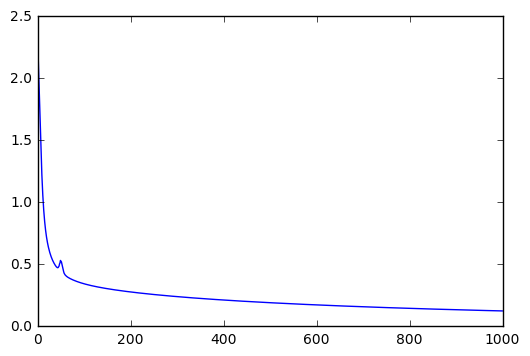

In [11]:
plt.plot(range(EPOCHS), costs, label="costs")

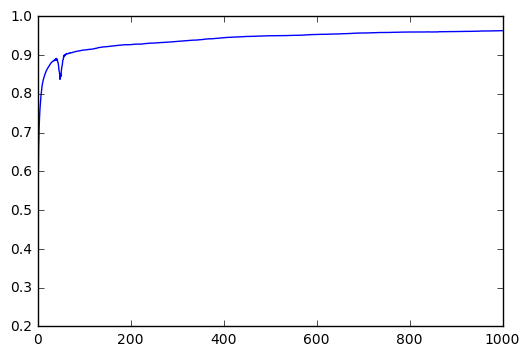

In [12]:
plt.plot(range(EPOCHS), vali_accuracy, label="validation accuracy")

Guess: [3]


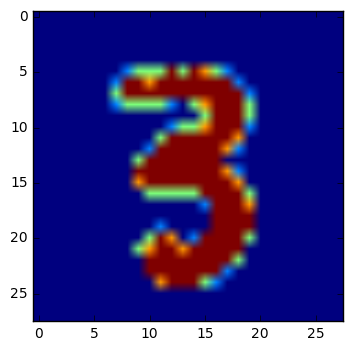

In [13]:
# Show random test image and calculated classification
rand_ind = np.random.randint(len(test_imgs))
guess = sess.run([feedforward], feed_dict={inputs: test_imgs[rand_ind:rand_ind+1]})
##guess = sess.run([feedforward], feed_dict={inputs: train_imgs, labels: train_labels})
print("Guess: {}".format(guess[0]))
plt.imshow(np.reshape(test_imgs[rand_ind], (IMAGE_SIZE, IMAGE_SIZE)))


## Restoring Variables from Files

In [14]:
##sess.run(tf.global_variables_initializer())
##saver = tf.train.Saver()
##saver.restore(sess, SAVE_FILE)